<a href="https://www.kaggle.com/code/itselif/m-zik-t-r-alg-lama-ve-s-n-fland-rma-sistemi-dl?scriptVersionId=239420965" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Derin Öğrenme Tabanlı Müzik Türü Tanıma: GTZAN Veri Kümesi ile Uygulamalı Bir Yaklaşım

![](https://media-hosting.imagekit.io/bdece186b7d94b31/ChatGPT%20Image%20May%2013,%202025,%2012_57_16%20AM.png?Expires=1841695610&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=fEv4aj10ijQUqmqTrWWY1YB-QLoBX7ea4jkJTFqt8N-kcGFwymmpTCac8UwXeFiH5T7FKBS-xozpYBo-M94isQIpb2GEGyBCdlvnOrgW2dQDB1R-NdiGqjtC4qU9-dTqUSa4Yo8~MDYmHcwBVFEQ0S8xjyGLG~TevS590yzFP-D6GCUhL2e-773-azURlMYNJaen2vmVVVKkdrRDWm~uvEjb1ottpPVJS5IOH8AE4jIlRL2rHPqjwGYWD1sK5c7obSTQi1~-geQ5Nmxx7uHhJOZ4BPgmelwU7JljkXvO-p0twaPdcxCh74fLx2WaZrzR-T~Cblqv0WpV26kgjXemrg__)

Projenin İngilizce versiyonuna **[buradan](https://www.kaggle.com/code/itselif/music-genre-classification-dl)** ulaşabilirsiniz.


Günümüzde dijital müzik platformlarının yaygınlaşmasıyla birlikte, müzik türlerinin otomatik olarak sınıflandırılması birçok uygulama açısından önem kazanmıştır. Bu tür sınıflandırmalar; müzik öneri sistemleri, içerik düzenleme algoritmaları ve medya arşivleme çözümleri gibi alanlarda kritik rol oynamaktadır. Ancak farklı türlere ait müziklerin birbirine benzer yapılar içerebilmesi, bu sınıflandırma sürecini oldukça karmaşık hale getirmektedir.

Bu projede, ses dosyalarından düşük seviyeli frekans ve zaman temelli öznitelikler çıkarılarak, derin öğrenme yöntemleri yardımıyla müzik türü sınıflandırması yapılması amaçlanmaktadır. Kullanılan veriler, bu tür bir sınıflandırma problemi için özel olarak oluşturulmuş olan GTZAN Music Genre Classification Dataset'inden alınmıştır.

GTZAN veri kümesi, 2000–2001 yılları arasında toplanmış olup, her biri 30 saniyelik 1000 ses dosyasından oluşmaktadır. Veri kümesinde toplam 10 farklı müzik türü bulunmaktadır.
* blues
* classical
* country
* disco
* hiphop
* jazz
* metal
* pop
* reggae
* rock
  
Her türe ait 100 örnek yer almaktadır. Tüm dosyalar .wav formatındadır ve benzer süre ve frekans aralığında oldukları için modelleme açısından uygun bir yapı sunmaktadır.

Bu çalışmada, ses sinyalleri üzerinde çeşitli sinyal işleme teknikleri ve öznitelik çıkarım yöntemleri (örneğin MFCC, Mel Spectrogram gibi) uygulanarak, bu özniteliklerin sınıflandırma modeline giriş olarak verilmesi planlanmaktadır. Amaç, modelin farklı müzik türlerini öğrenip ayırt edebilecek düzeye gelmesini sağlamak ve böylece ses tabanlı otomatik tür tanıma sistemlerinin geliştirilmesine katkı sunmaktır.

# 1. Kütüphaneleri İçe Aktarma

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

# Temel kütüphaneler
import os
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing

# Ses işleme
import librosa
import librosa.display
from IPython.display import Audio
import IPython.display as ipd

# Sinyal işleme
import scipy

# Görselleştirme
from tqdm import tqdm

# Makine öğrenmesi
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize, minmax_scale
from sklearn.feature_selection import RFECV, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

# Derin öğrenme
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D as MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize


from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from tempfile import TemporaryFile
# Jupyter notebook içi grafikler için
%matplotlib inline

2025-05-13 07:57:46.703753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747123066.892932      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747123066.949960      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Veri Kümesi Yolu ve Türlerin Listesi

In [2]:
org_genre= "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"

In [3]:
print(list(os.listdir(org_genre)))

['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


**Veri setimiz toplamda 10 adet müzik türü içermektedir.**

# 3. Ses Dosyalarının Yüklenmesi ve İncelenmesi

Bir ses sinyali, hava basıncındaki değişimlerin zamanla iletilmesiyle oluşur. Bu sinyaller genellikle belirli bir düzende tekrarlayan dalgalardan meydana gelir.
*Dalga yüksekliği*, yani *genlik* (amplitude), sesin ne kadar güçlü olduğunu gösterirken; bir dalganın tam bir döngüsünü tamamlaması için geçen süreye *periyot* (period), bir saniyede oluşan dalga sayısına ise *frekans* (frequency) denir.

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*7cuJJ-zV6pWA3Ping9AygA.png)

## 3.1. Örnek Ses Yükleme

Gerçek hayatta duyduğumuz sesler genellikle tek bir frekans değil; farklı frekansların birleşiminden oluşan daha karmaşık sinyallerdir. Bu sesler doğada analog formdadır. Ancak bilgisayarlar yalnızca dijital verilerle çalışabildiğinden, bu sinyallerin dijital hâle getirilmesi gerekir.

Bu dönüşüm iki temel adımı içerir:

* **Sampling (Örnekleme)**: Analog sinyalden belirli zaman aralıklarında veri alınması,

* **Quantization (Sayısallaştırma)**: Alınan örneklerin sayısal değerlere dönüştürülmesi.

Python'da bu işlemleri kolaylaştıran kütüphanelerden biri de *Librosa*’dır. Bu çalışmada ses verilerini işlemek ve analiz etmek için bu kütüphane kullanılmıştır.

In [4]:
y, sr = librosa.load(f'{org_genre}/reggae/reggae.00036.wav', duration=30)

In [5]:
ipd.Audio(y, rate=sr)

Ses dosyasını analiz etmek için rastgele bir müzik dosyası seçilmiş ve bu dosya *librosa.load()* fonksiyonu ile içe aktarılmıştır. 

    Fonksiyonun çıktısında yer alan;
    
    y: Ses sinyalinin genlik (amplitude) değerlerini içeren bir NumPy dizisidir. Bu değerler zaman içinde ses dalgasının nasıl değiştiğini gösterir.

    sr (sample rate): Örnekleme oranıdır. Saniyede kaç adet örnek (veri noktası) alındığını belirtir. Genellikle 22050 Hz olarak gelir.

    duration=30: Sesin yalnızca ilk 30 saniyesi yüklenmiştir. Daha uzun dosyalarda işlem süresini kısaltmak için kullanılır.

*ipd.Audio()* fonksiyonu ile yüklenen ses, Notebook ortamında çalınabilir hâle getirilmiştir.

## 3.2. Sesin Görselleştirilmesi

Ses verisiyle çalışırken, yalnızca dinleme yapmak genellikle yeterli olmaz. Verinin derinlemesine analizi, desenlerin tespiti ve anlamlı çıkarımlar yapabilmek için ses sinyalini görselleştirmek kritik bir adımdır. Zira, ham ses verisi (sayısal değerler halinde) tek başına incelendiğinde, içerdiği önemli bilgileri (örneğin frekans dağılımı, zamanla değişen enerji, harmonik yapılar) gözlemlemek neredeyse imkansızdır.

Bu noktada, zaman ve frekans domainlerinde sesi temsil eden görselleştirme teknikleri devreye girer. Bu teknikler sayesinde:

* Sinyalin hangi zaman aralığında ne kadar güçlü olduğunu,

* Hangi frekans bileşenlerini içerdiğini,

* Bu bileşenlerin zaman içinde nasıl evrildiğini net bir şekilde analiz edebiliriz.

Bu çalışmada Waveform, Fourier Transform (FT), Short-Time Fourier Transform (STFT), Spektrogram yöntemlerinden yararlanılmıştır.

### Waveform (Dalga Formu)

Waveform, sesin zaman içinde değişen genliğini (şiddetini) gösteren grafiktir.

* X ekseni: Zaman (saniye)

* Y ekseni: Genlik (amplitude)

**Waveform'un Önemi:**
> Müzik Prodüksiyonu: Miks mühendisleri, bu grafiği kullanarak enstrüman dengesizliklerini veya gürültüyü tespit eder.

> Makine Öğrenimi: Ses sınıflandırma modelleri için ham veri olarak kullanılır (örneğin, Reggae vs. Jazz ayrımı).

> Sanatsal Analiz: Müzikal yapıyı (verse/chorus geçişleri, dinamik kontrast) somutlaştırır.

Bu grafik, sesin ne zaman güçlü ya da zayıf olduğunu gösterir ama frekans bilgisi içermez. Yani bu ses tiz mi, bas mı anlayamayız. Bunu anlayabilmek için ilerleyen aşamalarda frekans alanı analizi yapılmalıdır.

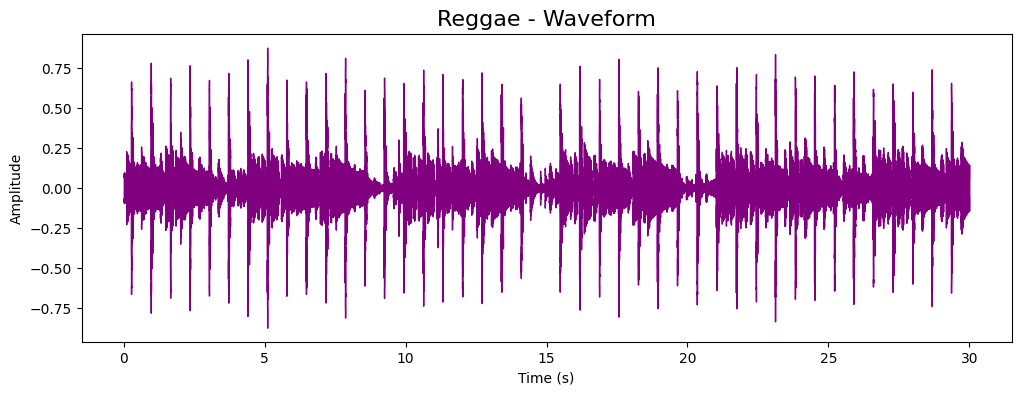

In [6]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, color="Purple")
plt.title("Reggae - Waveform", fontsize=16)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Grafik incelendiğinde genel olarak stabil bir yapıda olduğu dikkatimizi çekiyor. Şekildeki;
* **Yüksek Genlikli Bölgeler (±0.75 civarı)**: Şarkının *vurucu* anlarını temsil eder. Bu bölgeler büyük ihtimalle *davul vuruşları*, *bas gitar ritimleri* ya da *vokal patlamaları* gibi *enerjik* öğelerdir.
* **Düşük Genlikli Bölgeler (0'a yakın)**: Daha *sakin* veya *arka planda* kalan enstrümanlara işaret eder. Bu alanlar, *geçiş bölümleri* veya *introspektif melodiler* olabilir.
* **Sıkıştırma Etkisi (Compression)**: Genlik değerlerinin çoğunlukla ±0.75 aralığında kalması, sesin dinamik aralığının *bilinçli olarak* sınırlandığını, yani bir *kompresörle işlendiğini* gösterir. Bu durum, Reggae'nin tipik olarak dengeli ve rahatlatıcı ses karakteriyle uyumlu bir ses miksine işaret eder.

### Sessizlik Kırpma

Ses dosyasının başındaki ve sonundaki sessizlikler, veri analizini etkileyebilir. Bu yüzden *trim()* metodu ile gereksiz sessizlikler kaldırılarak yalnızca anlamlı sinyalin analize alınması sağlanır.

In [7]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [ 0.02072144  0.04492188  0.05422974 ... -0.05621338 -0.05187988
 -0.05194092] 

Audio File shape: (661500,)


### Fourier Transform (FT)

Waveform görselleştirmesinin, sesin yalnızca şiddetini, yani genliğini gösterdiğinden bahsetmiştik. 
Sesin tiz mi yoksa bas mı olduğunu anlamak için kullandığımız yöntemlerden birisi Fourier Transform (FT) yöntemidir.
Bu yöntem, bir sinyali frekans bileşenlerine ayırarak, sinyalin zaman içindeki değişimini frekanslar cinsinden incelememizi sağlar. Bu sayede, her bir frekansın sinyale ne kadar katkı sağladığını görebiliriz.

Ancak, klasik Fourier Transform yalnızca frekans bilgisi sunar ve zaman bilgisini kaybeder. Bu da demektir ki, hangi frekansların sinyale dahil olduğunu görebiliriz fakat bu frekansların ne zaman devreye girdiğini bilemeyiz.

Bu eksikliği gidermek için *Short-Time Fourier Transform (STFT)* kullanılır.

![](https://mriquestions.com/uploads/3/4/5/7/34572113/3311485_orig.gif)

### Short-Time Fourier Transform (STFT)

Bu yöntem, ses sinyalini küçük zaman dilimlerine ayırır ve her bir parça için ayrı Fourier Transform uygular. Böylece, hem frekans hem de zaman bilgisi elde edebiliriz, yani sesin ne zaman hangi frekans bileşenlerini içerdiğini görsel olarak inceleyebiliriz.

In [8]:
D = np.abs(librosa.stft(audio_file, n_fft=2048, hop_length=512))

* *n_fft*: Pencerenin boyutu (örnek sayısı)
* *hop_length*: Pencerelerin ne kadar kayarak ilerleyeceğini belirler.

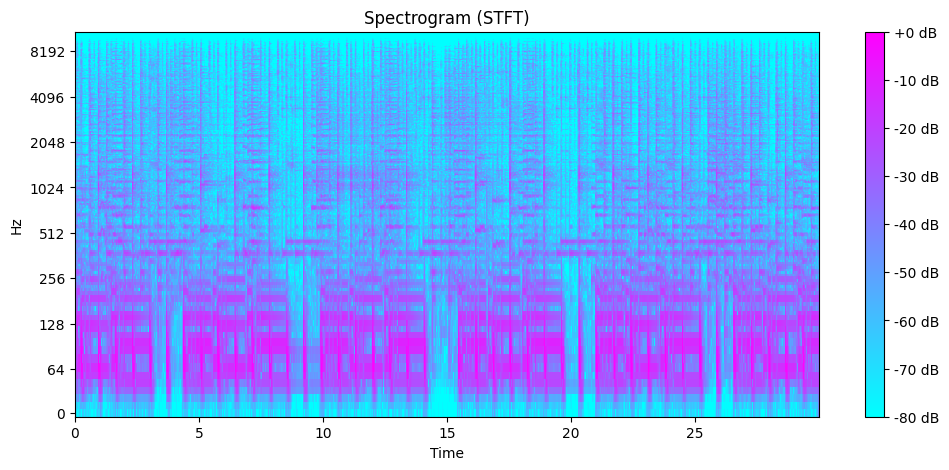

In [9]:
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(12, 5))
librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log', hop_length=512, cmap='cool')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.show()


STFT çıktısının görselleştirilmesiyle elde ettiğimiz bu spektrogram, sesin hem zamana hem de frekansa bağlı yapısını görmemizi sağlar. Spektogramdaki,
> **X ekseni**, zamanı (saniye cinsinden) temsil eder; sesin zamanla nasıl değiştiğini gösterir.
> 
> **Y ekseni**, frekansı (Hz cinsinden) ifade eder; sinyalde bulunan frekans bileşenlerinin aralığını gösterir.
> 
> **Renk yoğunluğu**, frekansların enerjisini veya genliğini desibel (dB) cinsinden belirtir. (Parlak renk = Yüksek ses)
>> **Pembe tonlar**, *yüksek* enerjili (yüksek sesli) frekansları,
>> 
>> **Mavi** tonlar ise *düşük* enerjili (daha sessiz) frekansları gösterir.

- Görselde ilk olarak 0–500 Hz aralığında yoğunluk dikkat çekiyor. Bu, sesin bas (low-frequency) bileşenlerinin güçlü olduğunu gösterir. Bu bölge, özellikle blues, hiphop, reggae gibi türlerde karakteristik olabilir. Bizim modelimizde bu aralıkta ciddi enerji olduğu için, bu parçanın bu türlerden birine ait olabileceğini düşünebiliriz. Model bu bilgiyi sınıflandırma için kullanabilir.
- 1000–4000 Hz aralığında ise orta düzeyde tekrar eden yapılar görülüyor. Bu frekanslar pop, rock, country gibi türlerde öne çıkar. Bu türlerde orta frekansların gücü, ritim veya vokal düzenini yakalamak için faydalı olabilir. Eğer model bu bölgede farklı türlere göre değişiklik tespit ederse, doğru tahminlerde bulunma ihtimali artar.
- 4000 Hz üzeri (özellikle 4096–8192 Hz) aralığı daha az enerji taşıyor. Bu, şarkının çok fazla tiz (high frequency) içermediğini gösterir. Ancak bazı "metal" ve "classical" türlerinde bu bölgeler daha aktif olabilir.

# 4. Özellik Çıkarımı (Feature Extraction) ve Sinyal İşleme

## 4.1. Mel Spectrogram

Mel Spectrogram, sesin zaman içinde değişen frekans bileşenlerini Mel ölçeğiyle gösteren bir görselleştirmedir. Mel ölçeği, insan kulağının frekans algısına daha yakındır. Bu nedenle model, sesin insan kulağına nasıl geldiğini daha iyi taklit edebilir.

-----------
* x ekseni zaman, y ekseni frekans (pes–tiz), renkler ise enerji (şiddet)
* Makine ne anlar: Hangi frekanslar ne kadar güçlü ve ne zaman baskın? Örn. gitar tınısı mı, davul mu, vokal mi? — Enstrüman, ritim, vokal ayrımı gibi detaylar.

In [10]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)

Bu kod bloğunda elde edilen S matrisi, ses sinyalinin mel ölçeğinde frekans-zaman düzleminde enerji yoğunluğunu *sayısal* bir metriğe dönüştürmektedir. Yani, ses verisi bu adımda bilgisayarın anlayabileceği biçimde, her bir zaman aralığında hangi frekans bileşeninin ne kadar enerji taşıdığını gösteren sayısal bir haritaya çevrilmiştir. 

*librosa.power_to_db* fonksiyonu ile bu enerji değerleri desibel (dB) cinsine dönüştürülerek logaritmik ölçeğe oturtulmuştur. Bu dönüşüm, insan kulağının ses algısına daha yakın bir gösterim sağlar. Böylece model, bu sayısallaştırılmış metrik üzerinden frekansların zaman içinde nasıl değiştiğini, hangi frekansların baskın olduğunu ve enerji yoğunluklarını öğrenerek müzik türünü tahmin etmeye çalışır.


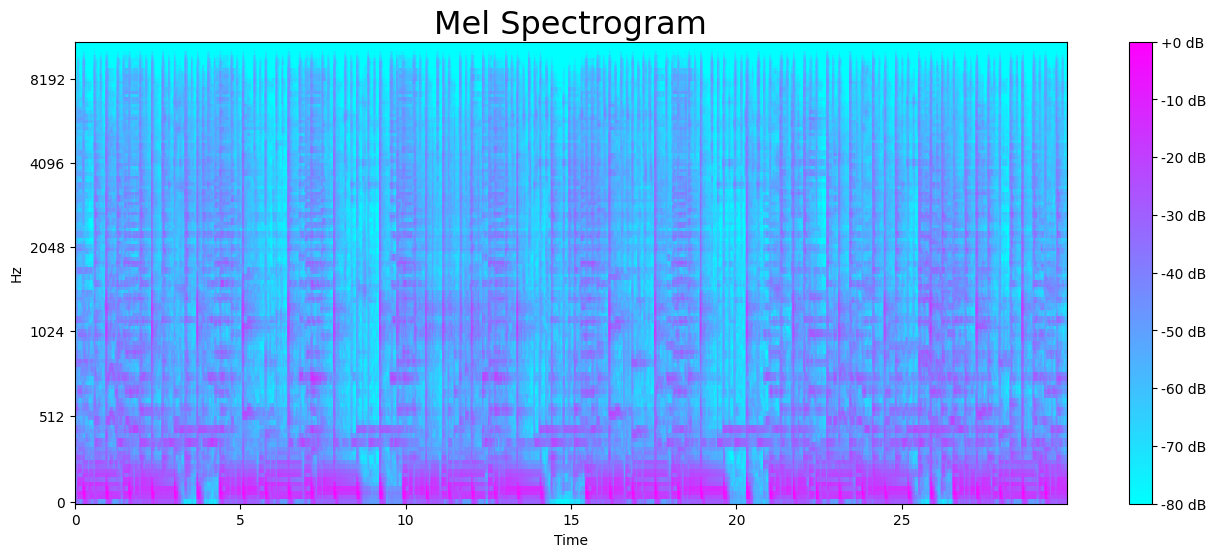

In [11]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='cool')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram", fontsize=23)
plt.show()

Görselde, zaman ekseni yatayda, frekans ekseni ise dikeyde yer almakta ve renk yoğunluğu sesin o anki frekans bileşenlerinin şiddetini (dB cinsinden) temsil etmektedir.

Grafikte mavi ve mor tonları baskın olup, bu bölgeler daha düşük enerjiye sahip frekansları temsil etmektedir. Örneğin, grafiğin alt kısmında ve zaman ekseninin çoğu noktasında görülen koyu mavi ve mor tonlar, düşük frekansta (örneğin 0–1000 Hz arası) yer alan ve düşük enerjiye sahip olan ses bileşenlerini göstermektedir. Bu, genellikle altyapı sesleri veya arka plandaki sürekli düşük frekanslı vuruşlar gibi öğeleri temsil eder.

Buna karşılık, grafikte zaman ekseninin bazı bölgelerinde (örneğin 5. saniye civarı veya 15–20. saniyeler arası) açık mavi ve pembe renk geçişlerinin olduğu kısımlar, bu noktalarda yüksek enerjili frekans bileşenlerinin yer aldığını göstermektedir. Bu da çoğunlukla vokal patlamaları, enstrüman geçişleri veya ritmin daha belirgin olduğu müzik anlarıyla ilişkilidir.

## 4.2. Mel-Frequency Cepstral Coefficients (MFCC)

MFCC, bir sesin frekans yapısındaki değişimleri temsil eden özniteliklerdir. *Sesin tınısını ve karakterini* oluşturan bileşenleri çıkarır ve bu sayede modelin sesi daha iyi anlamasını sağlar. Müzik türü tanıma gibi görevlerde bu öznitelikler oldukça önemlidir.

----------
Makine ne anlar: Sesin karakterini: Caz mı, metal mi? İnsan sesi mi, müzik mi

![](https://devopedia.org/images/article/340/9044.1621765887.png)

In [12]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

Bu satırda, y adlı ses sinyali için toplamda 13 adet MFCC katsayısı hesaplanmaktadır. sr örnekleme frekansı olup, sesin saniyede kaç örnekle temsil edildiğini gösterir. MFCC’ler sesin hem zaman hem frekans boyutundaki değişimlerini yansıtarak sesin temsili bir özetini oluşturur. Bu sayısal öznitelikler, model eğitimi sırasında giriş (input) olarak kullanılacaktır.

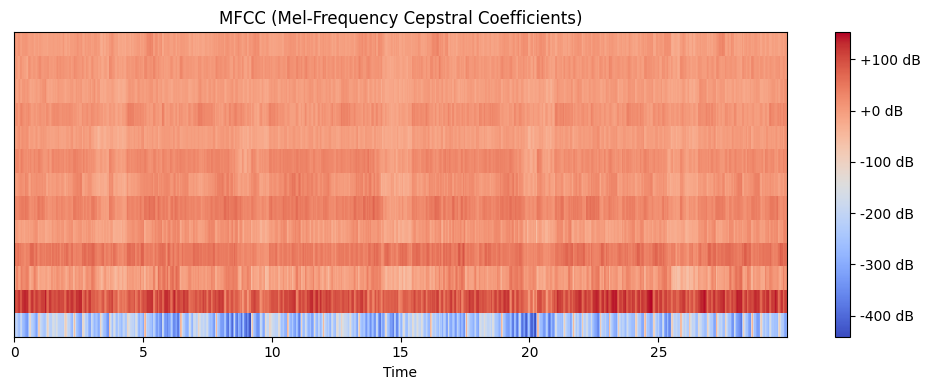

In [13]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC (Mel-Frequency Cepstral Coefficients)')
plt.tight_layout()
plt.show()

Bu grafik ise, ses sinyalinden elde edilen MFCC özniteliklerinin zaman içindeki değişimini görsel olarak sunar. Görsel sadece analiz için kullanılsa da, model eğitimi sırasında MFCC matrisinin kendisi, modelin öğrenmesi için doğrudan kullanılır.

## 4.3. Spectral Centroid

Bu öznitelik, sesin "parlaklığını (tiz mi pes mi)" temsil eder. Frekans spektrumunun ağırlık merkezini gösterir. Örneğin metal ve rock gibi daha tiz frekans içeren türlerde centroid daha yüksektir.

-------
Makine ne anlar: Sesin genel karakteri. Örneğin bir flüt parçası daha parlak olabilirken, bas gitar koyudur.

In [14]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(y=audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [1758.29476432 1946.74243678 2038.8113414  ...  846.53893707  766.50390945
 1082.07265111] 

Shape of Spectral Centroids: (1292,) 

frames: range(0, 1292) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99305215e+01
 2.99537415e+01 2.99769615e+01]


Bu kod bloğunda, bir ses dosyasının spektral özelliklerinden biri olan spectral centroid (spektral ağırlık merkezi) hesaplanarak, sesin frekans içeriği zaman ekseninde analiz edilmiştir. Spektral centroid, her bir kısa zaman aralığında (frame) sesin ağırlık merkezini temsil eden frekans değerlerini verir ve sesin daha çok tiz mi yoksa pes mi olduğunu belirlemeye yardımcı olur. Bu değerler zaman bilgisine dönüştürülerek sesin zamana göre frekanssal davranışı çıkarılmıştır. Ayrıca, elde edilen bu değerler min-max normalizasyonu yöntemiyle 0-1 aralığına ölçeklendirilmiş ve böylece ses verisi sayısal bir forma getirilerek, hem görselleştirme hem de modelin öğrenebileceği yapıya uygun hale getirilmiştir.

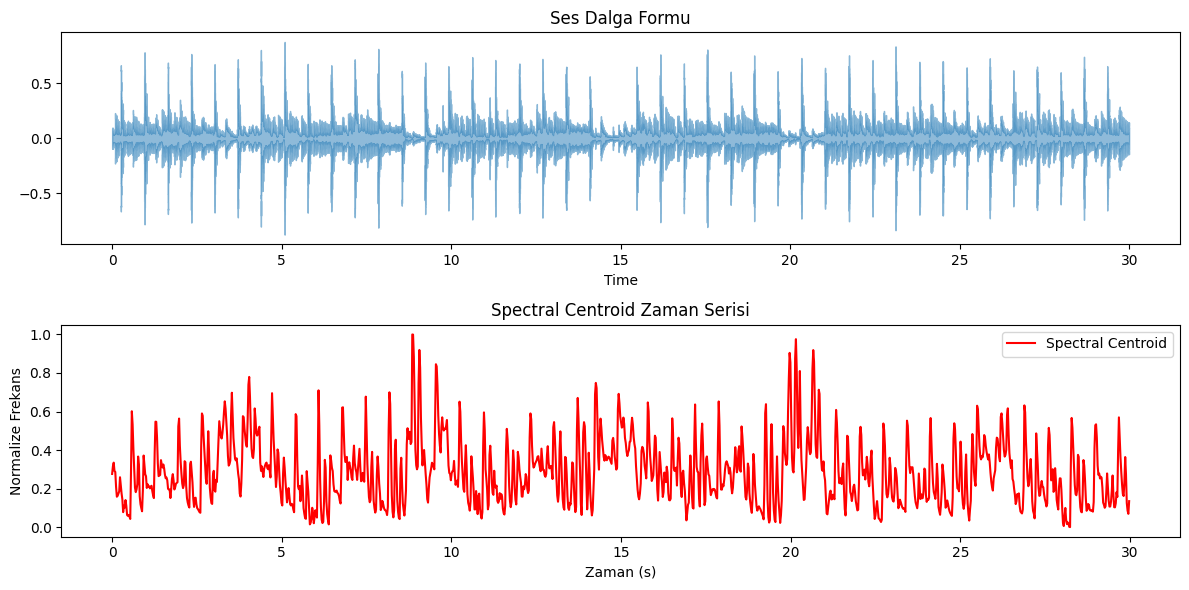

In [15]:
# Görselleştirme
plt.figure(figsize=(12, 6))

# Ham ses dalgası
plt.subplot(2, 1, 1)
librosa.display.waveshow(y=audio_file, sr=sr, alpha=0.5)
plt.title('Ses Dalga Formu')

# Spectral centroid
plt.subplot(2, 1, 2)
normalize = sklearn.preprocessing.minmax_scale
normalized_centroids = normalize(spectral_centroids)
plt.plot(t, normalized_centroids, color='r', label='Spectral Centroid')
plt.title('Spectral Centroid Zaman Serisi')
plt.xlabel('Zaman (s)')
plt.ylabel('Normalize Frekans')
plt.legend()
plt.tight_layout()
plt.show()

## 4.4. Spectral Rolloff

Spectral roll-off, ses sinyalindeki enerjinin belirli bir yüzdesinin (genellikle %85) altındaki frekans sınırını ifade eder ve genellikle sesin yüksek frekans içeriğini tanımlamada kullanılır. Bu sayede bir sesin ne kadar tiz veya pes frekanslar içerdiği anlaşılabilir.Daha tiz veya keskin seslerin olduğu türlerde bu değer daha yüksektir. Özellikle sesin yoğunluğunu veya "netliğini" ölçmek için kullanılır.

---------
Makine ne anlar: Özellikle yüksek frekanslı enstrüman var mı yok mu (örneğin zil sesi vs), tını ne kadar geniş?

In [16]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_file+0.01, sr=sr)[0]
t = librosa.frames_to_time(range(len(spectral_rolloff)), sr=sr)

# Normalizasyon fonksiyonu
def normalize(x):
    return minmax_scale(x)

Bu kod bloğunda, ses sinyalinin spectral roll-off (spektral düşüm) özelliği hesaplanmıştır. amanla birlikte değişen bu değerler, librosa.frames_to_time fonksiyonu kullanılarak zaman eksenine dönüştürülmüştür. Ardından, elde edilen spektral roll-off değerleri min-max normalizasyon yöntemiyle 0 ile 1 arasına ölçeklendirilmiş ve bu sayede ses sinyali sayısal bir metriğe dönüştürülerek hem analiz hem de model eğitimi için uygun hale getirilmiştir.

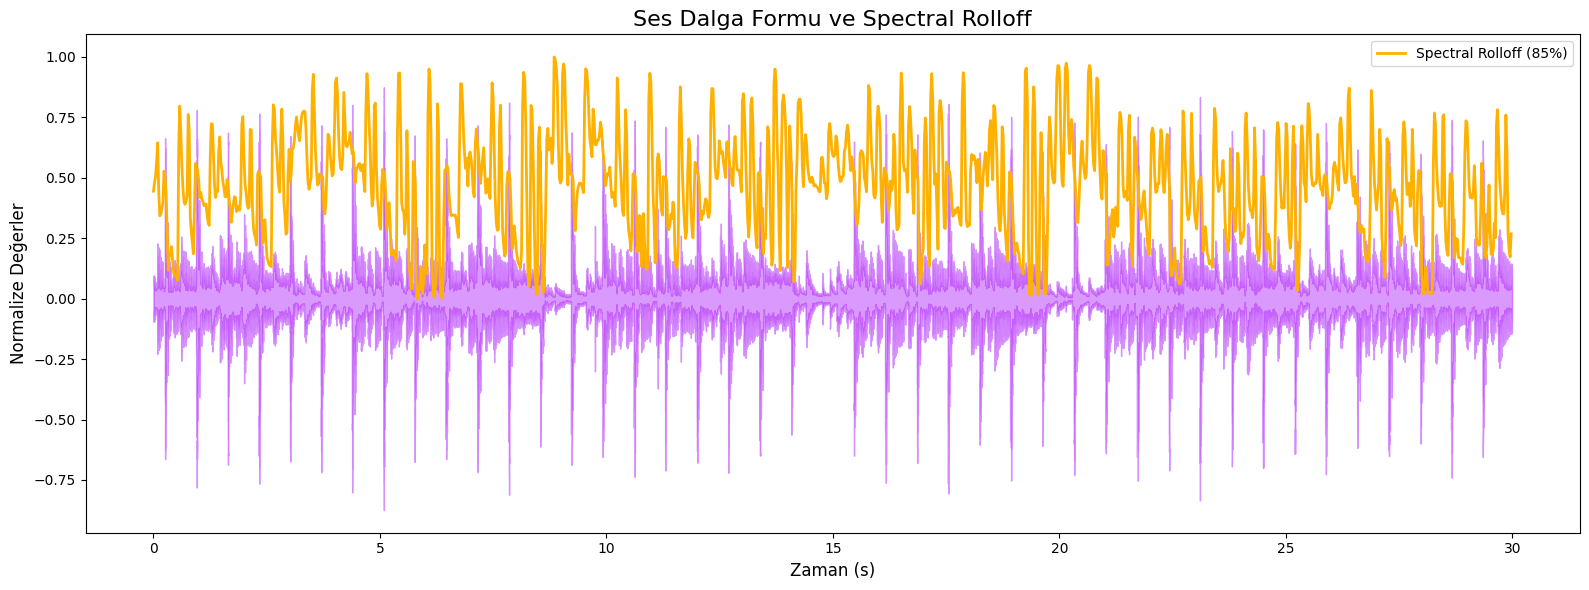

In [17]:
plt.figure(figsize=(16, 6))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.4, color='#A300F9')
plt.plot(t, normalize(spectral_rolloff), color='#FFB100', linewidth=2, label='Spectral Rolloff (85%)')

# Grafik ayarları
plt.title('Ses Dalga Formu ve Spectral Rolloff', fontsize=16)
plt.xlabel('Zaman (s)', fontsize=12)
plt.ylabel('Normalize Değerler', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

## 4.5. Chroma Frequencies

Chroma özellikleri, sesin armonik içeriğine odaklanır ve genellikle 12 yarı sesli müzik notası (C, C#, D, … B) baz alınarak hesaplanır. Melodilerdeki akor yapısını, notaların dağılımını gösterdiği için özellikle klasik, caz gibi türlerin ayrımında faydalı olabilir.

----------
Makine ne anlar: Melodi, harmoni, kullanılan nota dizileri. Klasik müzikteki akor yapısı ile rock müzikteki fark buradan ayırt edilebilir.

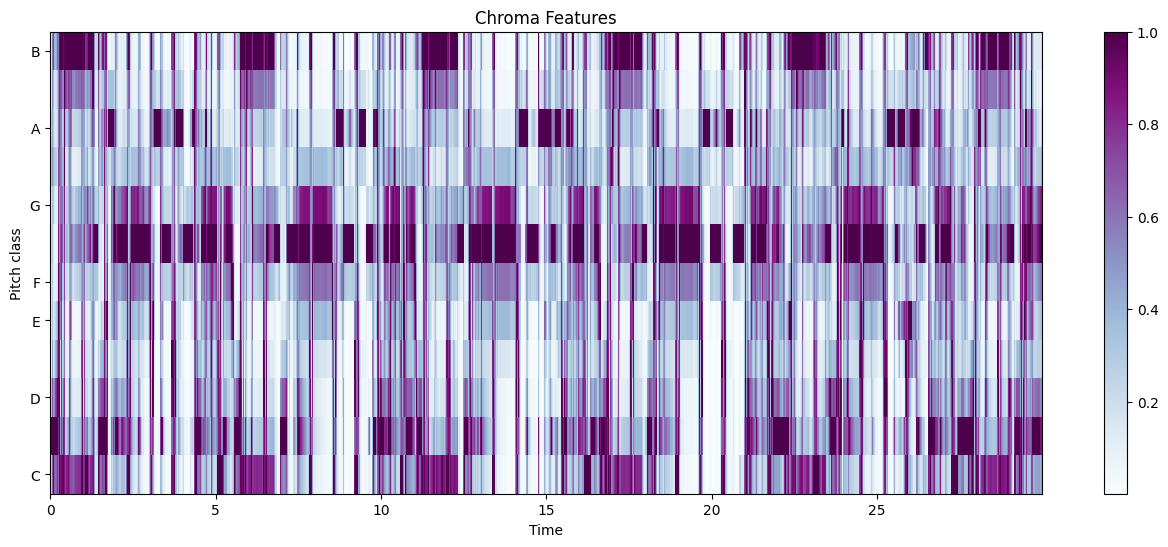

In [18]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(16,6))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='BuPu')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

# 5. Model Eğitimi

Yukarıda, seçilen tek bir müzik parçası üzerinde çeşitli ses özniteliklerini (Mel spectrogram, MFCC, Chroma vb.) çıkararak genel bir analiz gerçekleştirdik. Ancak bir makine öğrenmesi modeli eğitmek için bu işlemin yalnızca tek bir örnek üzerinde yapılması yeterli değildir. Modelin, tüm veri kümesini öğrenebilmesi için her bir ses dosyasına aynı öznitelik çıkarım işlemlerinin uygulanması gerekir. Bu nedenle yazdığımız kod, veri kümesindeki tüm müzik dosyalarını sistematik bir şekilde işleyerek her biri için öznitelikleri otomatik olarak çıkarmakta ve model eğitiminde kullanılabilecek şekilde yapılandırılmış bir veri seti oluşturmaktadır.

----------------------------

    classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

    def extract_features(audio_data, sample_rate, target_shape=(150, 150)):
        features = []
        
        # 1. Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_spec = resize(np.expand_dims(mel_spec, axis=-1), target_shape)
        features.append(mel_spec.numpy())
    
        # 2. MFCC
        mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
        mfcc = resize(np.expand_dims(mfcc, axis=-1), target_shape)
        features.append(mfcc.numpy())
    
        # 3. Chroma Frequencies
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
        chroma = resize(np.expand_dims(chroma, axis=-1), target_shape)
        features.append(chroma.numpy())
    
        return np.concatenate(features, axis=-1)  # Shape: (150, 150, 3)
    
    def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
        data = []
        labels = []
        
        for label_idx, genre in enumerate(classes):
            genre_dir = os.path.join(data_dir, genre)
            print(f"Processing {genre}...")
            
            for filename in os.listdir(genre_dir):
                if filename.endswith('.wav'):
                    file_path = os.path.join(genre_dir, filename)
                    try:
                        audio, sr = librosa.load(file_path, sr=22050)  # Standard sample rate
                        
                        # 3 saniyelik segmentler halinde işleme (2 saniye örtüşmeli)
                        segment_length = 3 * sr
                        hop_length = 1 * sr
                        
                        for start in range(0, len(audio), hop_length):
                            end = start + segment_length
                            if end > len(audio):
                                break
                                
                            segment = audio[start:end]
                            features = extract_features(segment, sr, target_shape)
                            data.append(features)
                            labels.append(label_idx)
                    except Exception as e:
                        print(f"Error processing {filename}: {str(e)}")
                        continue
    
        return np.array(data), np.array(labels)
    
    # Kullanım
    data, labels = load_and_preprocess_data(org_genre, classes)
    print(f"Final data shape: {data.shape}")  # (n_samples, 150, 150, 3)
    print(f"Labels shape: {labels.shape}")
    
    # Veriyi kaydetme (opsiyonel)
    np.save('gtzan_features.npy', data)
    np.save('gtzan_labels.npy', labels)

---------------------------------

Başlangıçta Mel Spectrogram, MFCC ve Chroma Frequencies gibi üç farklı ses özniteliği çıkarım yöntemi kullanılarak veri ön işleme gerçekleştirilmiştir. Ancak bu işlem yüksek bellek kullanımı ve işlem süresi açısından verimli olmadığından, sistem kaynaklarını daha etkin kullanmak amacıyla yalnızca Mel Spectrogram özelliğiyle devam edilmesine karar verilmiştir.
* Yukarıdaki kod örneğinde üçünün de çıkarımına dair detayları bulabilirsiniz.

In [19]:
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []

    for label_idx, genre in enumerate(classes):
        genre_dir = os.path.join(data_dir, genre)
        print(f"Processing -- {genre}")

        for filename in os.listdir(genre_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_dir, filename)
                try:
                    audio, sr = librosa.load(file_path, sr=22050)

                    # Chunk ayarları
                    chunk_duration = 4  # saniye
                    overlap_duration = 2  # saniye

                    chunk_samples = chunk_duration * sr
                    overlap_samples = overlap_duration * sr

                    num_chunks = int(np.ceil((len(audio) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

                    for i in range(num_chunks):
                        start = i * (chunk_samples - overlap_samples)
                        end = start + chunk_samples
                        if end > len(audio):
                            break
                        chunk = audio[start:end]

                        # Sadece Mel Spectrogram çıkarımı (CPU'yu az yorar)
                        mel_spec = librosa.feature.melspectrogram(y=chunk, sr=sr)
                        mel_spec = resize(np.expand_dims(mel_spec, axis=-1), target_shape)
                        data.append(mel_spec.numpy())
                        labels.append(label_idx)
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
                    continue

    return np.array(data), np.array(labels)
    
data_dir = org_genre
data, labels = load_and_preprocess_data(data_dir, classes)
print("Final data shape:", data.shape)
print("Labels shape:", labels.shape)

# İsteğe bağlı kaydetme
np.save('gtzan_mel_features.npy', data)
np.save('gtzan_mel_labels.npy', labels)


Processing -- blues


I0000 00:00:1747123102.655013      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Processing -- classical
Processing -- country
Processing -- disco
Processing -- hiphop
Processing -- jazz


/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing jazz.00054.wav: 
Processing -- metal
Processing -- pop
Processing -- reggae
Processing -- rock
Final data shape: (13977, 150, 150, 1)
Labels shape: (13977,)


In [20]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes = len(classes)) # Converting labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Sınıf etiketleri, one-hot encoding formatına dönüştürülerek her sınıfın sayısal karşılığı (örneğin 0, 1, 2...) 0 ve 1'lerden oluşan vektörlere çevrilmiştir. Bu sayede veriler, modelin anlayabileceği uygun forma getirilmiş olur.


In [21]:
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

In [22]:
model = tf.keras.models.Sequential()

# Giriş katmanı
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# 2. blok
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# 3. blok
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.3))

# 4. blok
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# 5. blok
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.3))

# Flatten ve fully connected katmanlar
model.add(Flatten())
model.add(Dense(units=1200, activation='relu'))
model.add(Dropout(0.45))

# Çıkış katmanı
model.add(Dense(units=len(classes), activation='softmax'))

# Model özeti
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

Müzik türü sınıflandırma problemi için tasarladığımız CNN (Convolutional Neural Network) mimarisi modelinin özetini tabloda görebilirsiniz.

In [23]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

#Training Model
training_history = model.fit(X_train,Y_train,epochs=30,batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/30


I0000 00:00:1747123264.785146      70 service.cc:148] XLA service 0x7b9ae8004630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747123264.785787      70 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747123265.313391      70 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/350 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.0503 - loss: 2.5476   

I0000 00:00:1747123273.467884      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - accuracy: 0.1880 - loss: 2.1448 - val_accuracy: 0.4056 - val_loss: 1.6725
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4551 - loss: 1.5232 - val_accuracy: 0.5919 - val_loss: 1.1891
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5785 - loss: 1.1928 - val_accuracy: 0.6398 - val_loss: 1.0461
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.6621 - loss: 0.9790 - val_accuracy: 0.6964 - val_loss: 0.8664
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.7146 - loss: 0.8284 - val_accuracy: 0.7432 - val_loss: 0.7687
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.7657 - loss: 0.6848 - val_accuracy: 0.7736 - val_loss: 0.6918
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8021 - loss: 0.5766 - val_accuracy: 0.7811 - val_loss: 0.6622
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8304 - loss: 0.5006 - val_accurac

# 6. Model Performansının Analizi ve Değerlendirmesi

In [24]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

#Reloading Training history
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)

training_history_data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

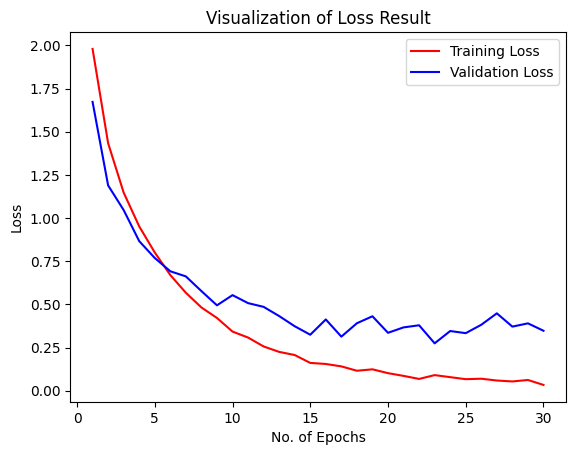

In [25]:
#Visualization of Loss
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history_data['val_loss'],label="Validation Loss",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

Bu grafik, modelin eğitim ve doğrulama kayıp (loss) değerlerinin epoch sayısına göre değişimini göstermektedir. Epoch sayısı arttıkça hem eğitim kaybı hem de doğrulama kaybı belirgin şekilde azalmıştır. Kayıp değerleri yaklaşık 25-30 epoch sonra düşük seviyelere inmiş ve stabilize olmuştur. Bu, modelin başarılı bir şekilde öğrendiğini ve daha fazla eğitimin fayda sağlamayabileceğini gösterir. Eğitim ve doğrulama kayıpları birbirine paralel olarak azalmış ve aralarında belirgin bir fark oluşmamıştır. Bu, kullanılan optimizasyon yönteminin ve öğrenme oranının uygun olduğunu, ayrıca modelin aşırı uyum göstermediğini ve iyi bir genelleme yeteneğine sahip olduğunu gösterir.

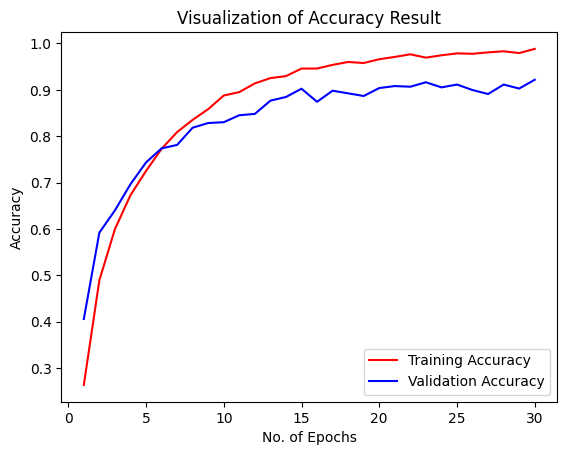

In [26]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history_data['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

Modelin eğitim ve doğrulama doğrulukları epoch sayısı arttıkça belirgin şekilde yükselmiştir ve yaklaşık 0.8-0.9 seviyelerine ulaşarak son epoch’larda stabilize olmuştur. Bu, modelin başarılı bir şekilde öğrendiğini ve sınıflandırma görevinde iyi performans sergilediğini gösterir. Eğitim ve doğrulama doğruluklarının birbirine yakın olması, overfitting (aşırı uyum) belirtisi olmadığını ve modelin genelleme yeteneğinin iyi olduğunu gösterir. Eğitim süreci kararlı bir şekilde ilerlemiş ve hiperparametreler uygun şekilde ayarlanmış. Sonuç olarak, model hem eğitim hem de doğrulama setlerinde yüksek doğruluk değerlerine ulaşmış ve başarılı bir şekilde genelleme yapmıştır.

In [27]:

y_pred = model.predict(X_test)
predicted_categories = np.argmax(y_pred,axis=1)
true_categories = np.argmax(Y_test,axis=1)

from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)

# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
              precision    recall  f1-score   support

       blues       0.92      0.92      0.92       290
   classical       0.95      0.95      0.95       272
     country       0.78      0.96      0.86       296
       disco       0.94      0.95      0.94       263
      hiphop       0.97      0.97      0.97       294
        jazz       0.93      0.95      0.94       269
       metal       0.96      0.93      0.95       289
         pop       0.95      0.91      0.93       296
      reggae       0.93      0.93      0.93       257
        rock       0.94      0.75      0.83       270

    accuracy                           0.92      2796
   macro avg       0.93      0.92      0.92      2796
weighted avg       0.93      0.92      0.92      2796



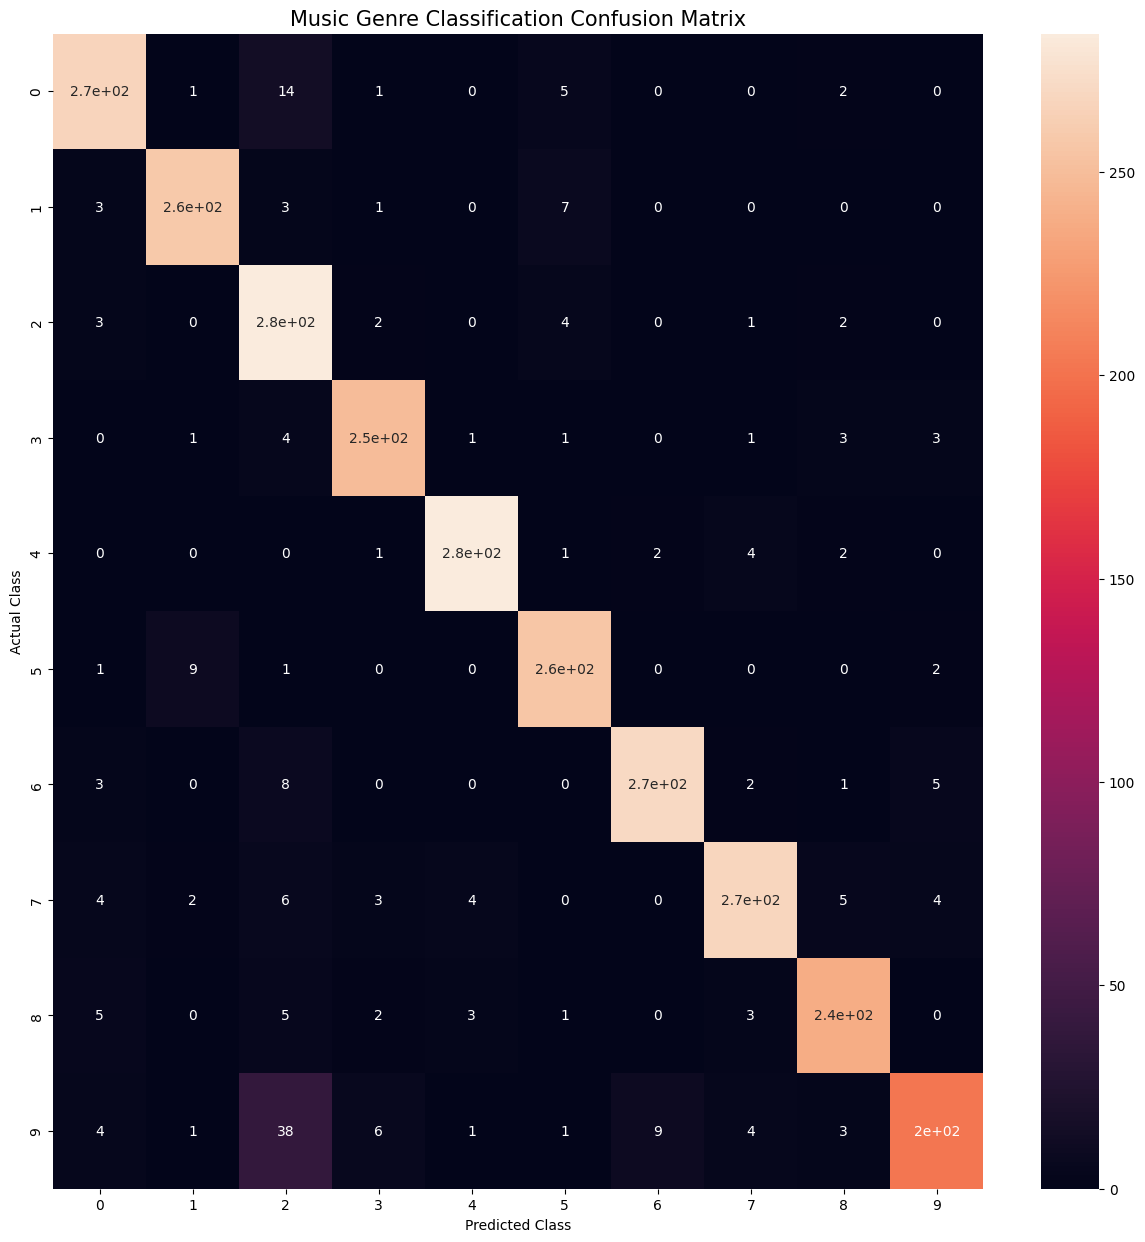

In [28]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()

Modelin sınıflandırma performansı, her bir müzik türü için belirli metrikler (precision, recall, f1-score) ile değerlendirilmiştir. Genel olarak, modelin doğru sınıflandırma yeteneği oldukça yüksektir:

* Precision: Modelin, her bir sınıf için doğru olarak tahmin ettiği örneklerin oranı oldukça yüksek. Örneğin, hip-hop ve metal türlerinde precision değeri 0.95 civarında. Bu, modelin doğru tahminlerde bulunma konusunda güvenilir olduğunu gösterir.

* Recall: Her bir sınıfın doğru olarak tespit edilme oranı da oldukça yüksek. Örneğin, disco türü için recall değeri 0.98, bu da modelin bu türü çok iyi tespit ettiğini gösterir.

* F1-Score: Precision ve recall'un dengeli olduğu f1-score, genellikle modelin genel başarısını temsil eder. Modelin f1-scorenın çoğu sınıfta 0.90'ın üzerinde olması, modelin iyi bir dengeye sahip olduğunu ve hem doğruluk hem de duyarlılık açısından başarılı olduğunu gösterir.

* Genel Performans: Modelin genel doğruluğu (accuracy) %91 olarak hesaplanmıştır. Bu, modelin tüm sınıflarda doğru tahminlerde bulunma oranının yüksek olduğunu gösterir.

* Macro ve Weighted Average: Macro avg ve weighted avg metrikleri de sırasıyla 0.92 ve 0.91 değerlerinde, yani modelin genel başarısı tüm sınıflar için tutarlı ve dengelidir.

**Sonuç olarak**, modeliniz yüksek doğruluk, precision, recall ve f1-score değerleriyle başarılı bir sınıflandırma gerçekleştirmiştir. Aşırı uyum (overfitting) ve dengesiz sınıflandırma belirtileri gözlemlenmemiştir.